In [2]:
import torch
import pytest
import os
import numpy as np

from bliss.models import decoder

torch.manual_seed(84)
np.random.seed(43)



In [14]:
pwd

'/home/runingli/astronomy/celeste/bryan_notebooks'

In [15]:
# psf_file = os.path.join(paths["data"], "psField-002583-2-0136.fits")

psf_file = '../data/psField-002583-2-0136.fits'

In [16]:
from bliss.models.decoder import fits

# Train sleep phase

In [3]:
# create training dataset
n_bands = 2
max_stars = 2500
mean_stars = 1200
min_stars = 0
f_min = 1e3
f_max = 1000000
alpha = 0.5
slen = 100

# set background
background = torch.zeros(n_bands, slen, slen, device=device)
background[0] = 686.0
background[1] = 1123.0

### Get PSF

In [4]:
psf_file = os.path.join(path, 'data/psField-002583-2-0136.fit')
init_psf_params = psf_transform.get_psf_params(psf_file, bands = [2, 3])
power_law_psf = psf_transform.PowerLawPSF(init_psf_params.to(device))
psf_og = power_law_psf.forward().detach()

### Data loader

In [5]:
# simulate dataset
n_images = 200
simulator_args = (
    None,
    psf_og,
    background,
)

simulator_kwargs = dict(
    slen=slen,
    n_bands=n_bands,
    prob_galaxy=0.0, 
    max_sources=max_stars,
    mean_sources=mean_stars,
    min_sources=min_stars,
    f_min=f_min,
    f_max=f_max, 
    alpha=alpha
)

In [6]:
dataset = simulated_datasets.SourceDataset(
    n_images, simulator_args, simulator_kwargs
)

In [7]:
# draw one image and inspect
batch = dataset.get_batch(1)

In [12]:
batch['galaxy_params'].shape

torch.Size([1, 2500, 2])

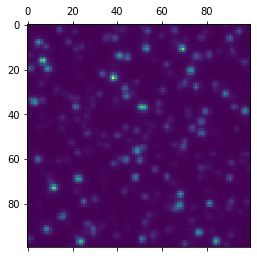

In [8]:
plt.matshow(batch['images'][0, 0].cpu())

In [9]:
from celeste.plotting import plot_subimage

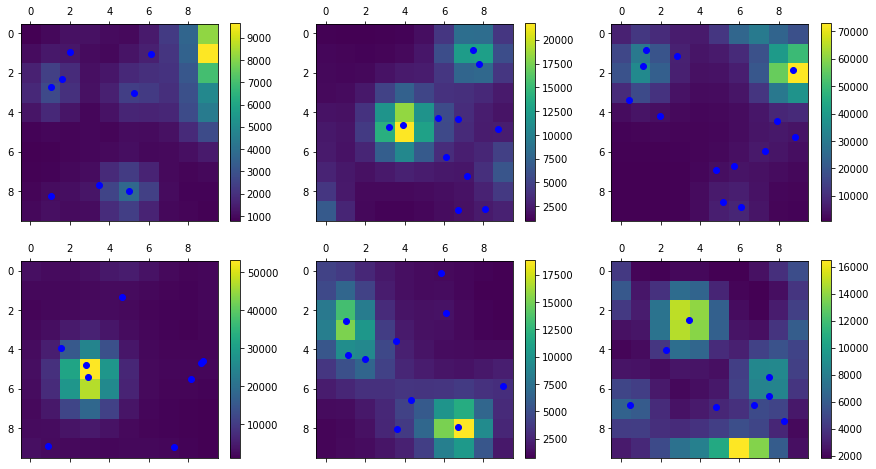

In [10]:
# plot six subimages
x_vec = np.linspace(0, slen - 10, 11)
fig, axarr = plt.subplots(2, 3, figsize=(15, 8))

for i in range(6): 
    x0 = int(np.random.choice(x_vec, 1))
    x1 = int(np.random.choice(x_vec, 1))


    # my catalog
    plot_subimage(axarr[i // 3, i % 3], 
                  batch['images'][0, 0].cpu(), 
                  None, 
                  batch['locs'][0].cpu(), 
                  x0, x1, 
                  subimage_slen = 10, 
                add_colorbar = True, 
                global_fig = fig)

### Set up star encoder

In [13]:
dataset.simulator.latent_dim

2

In [11]:
star_encoder = sourcenet.SourceEncoder(
    slen=slen,
    ptile_slen=8,
    step=2,
    edge_padding=3,
    n_bands=n_bands,
    max_detections=2,
    n_galaxy_params=dataset.simulator.latent_dim,
    enc_conv_c=20,
    enc_kern=3,
    enc_hidden=256
).to(device)


# Run sleep

In [12]:
SleepTraining = train.SleepTraining(
    model=star_encoder,
    dataset=dataset,
    slen=slen,
    n_bands=n_bands,
    verbose=True,
    batchsize=20,
)

n_epochs = 150 if use_cuda else 1
SleepTraining.run(n_epochs=n_epochs)

0 loss: 22.4015; counter loss: 1.0167; locs loss: 0.7390; galaxy_params loss: 0.0000; star_params_loss: 20.5050; galaxy_bool_loss: 0.1408	 [7.8 seconds]
1 loss: 7.5506; counter loss: 0.7830; locs loss: 0.3528; galaxy_params loss: 0.0000; star_params_loss: 6.3438; galaxy_bool_loss: 0.0711	 [6.9 seconds]
2 loss: 4.9651; counter loss: 0.7254; locs loss: 0.1649; galaxy_params loss: 0.0000; star_params_loss: 4.0455; galaxy_bool_loss: 0.0294	 [6.9 seconds]
3 loss: 4.2450; counter loss: 0.6882; locs loss: 0.1188; galaxy_params loss: 0.0000; star_params_loss: 3.4238; galaxy_bool_loss: 0.0143	 [6.8 seconds]
4 loss: 3.9415; counter loss: 0.6604; locs loss: 0.0833; galaxy_params loss: 0.0000; star_params_loss: 3.1896; galaxy_bool_loss: 0.0083	 [8.0 seconds]
5 loss: 3.7727; counter loss: 0.6416; locs loss: 0.0478; galaxy_params loss: 0.0000; star_params_loss: 3.0778; galaxy_bool_loss: 0.0055	 [8.2 seconds]
6 loss: 3.6205; counter loss: 0.6234; locs loss: 0.0095; galaxy_params loss: 0.0000; star_pa

In [13]:
outfile = './starnet_m2'
torch.save(star_encoder.state_dict(), outfile)

# Check sleep

In [14]:
star_encoder.eval();

In [15]:
# load hubble parameters and sdss image 
hubble_data = np.load('../data/true_hubble_m2.npz')

test_image = torch.Tensor(hubble_data['sdss_image']).unsqueeze(0).to(device)
true_locs = torch.Tensor(hubble_data['true_locs']).to(device)
true_fluxes = torch.Tensor(hubble_data['true_fluxes']).to(device)
nelec_per_nmgy = torch.Tensor(hubble_data['nelec_per_nmgy']).to(device)

In [16]:
n_sources, est_locs, galaxy_params, est_log_fluxes, galaxy_bool = \
    star_encoder.sample_encoder(
        test_image.to(device),
        n_samples=1,
        return_map_n_sources=True,
        return_map_source_params=True
)

In [17]:
est_fluxes = est_log_fluxes.exp()

In [18]:
from celeste import image_statistics

In [19]:
sleep_tpr, sleep_ppv = \
    image_statistics.get_summary_stats(est_locs[0], 
                                        true_locs, 
                                        star_encoder.slen, 
                                        est_fluxes[0, :, 0], 
                                        true_fluxes[:, 0], 
                                        nelec_per_nmgy)[0:2]


In [20]:
sleep_tpr

tensor(0.5048, device='cuda:0')

In [21]:
sleep_ppv

tensor(0.4041, device='cuda:0')

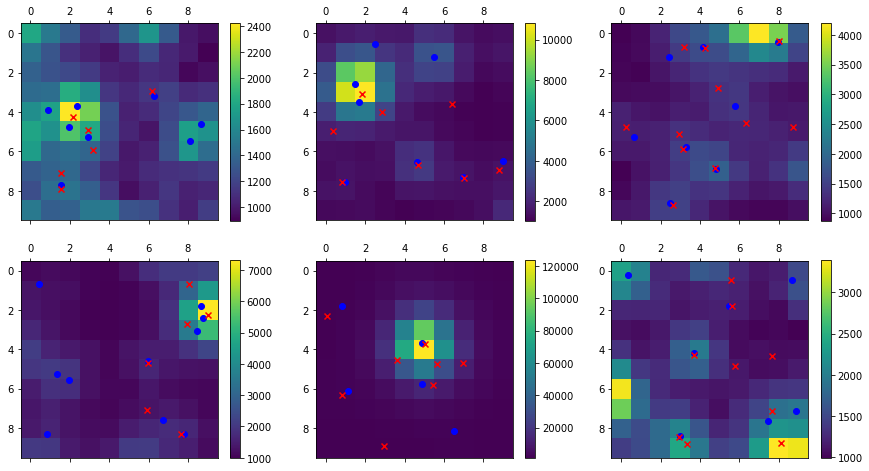

In [31]:
# plot six subimages
x_vec = np.linspace(0, slen - 10, 11)
fig, axarr = plt.subplots(2, 3, figsize=(15, 8))

for i in range(6): 
    x0 = int(np.random.choice(x_vec, 1))
    x1 = int(np.random.choice(x_vec, 1))


    # my catalog
    plot_subimage(axarr[i // 3, i % 3], 
                  test_image[0, 0].cpu(), 
                  est_locs[0].cpu().detach(), 
                  true_locs.cpu(), 
                  x0, x1, 
                  subimage_slen = 10, 
                add_colorbar = True, 
                global_fig = fig)

# Run wake

In [23]:
true_psf = psf_transform.PowerLawPSF(true_psf_params).forward().detach()
init_psf = psf_transform.PowerLawPSF(init_psf_params).forward().detach()

NameError: name 'true_psf_params' is not defined

In [ ]:
def compare_psfs(psf1, psf2, fig, axarr, band = 0): 
    
    psf1 = psf1.cpu()[band, 40:60, 40:60]
    psf2 = psf2.cpu()[band, 40:60, 40:60]
    
    vmax = max(psf1.abs().max(), psf2.abs().max())
    print(vmax)
    
    im0 = axarr[0].matshow(psf1, cmap=plt.cm.Blues, vmax = vmax, vmin = 0)
    fig.colorbar(im0, ax = axarr[0])

    im1 = axarr[1].matshow(psf2, cmap=plt.cm.Blues, vmax = None, vmin = 0)
    fig.colorbar(im1, ax = axarr[1])

    psf_resid = (psf1- psf2)
    im2 = axarr[2].matshow(psf_resid, 
                           vmax = psf_resid.abs().max(), vmin = -psf_resid.abs().max(), 
                           cmap = plt.get_cmap('bwr'))
    axarr[2].set_title('Diff')

    fig.colorbar(im2, ax = axarr[2])

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 4))

compare_psfs(true_psf, init_psf, fig, axarr)
axarr[0].set_title('True PSF')
axarr[1].set_title('Init PSF')

In [ ]:
# run the wake-phase training
n_epochs = 400 if use_cuda else 1

star_encoder.eval()
estimate_params, map_loss = wake.run_wake(
    test_image.to(device),
    star_encoder,
    init_psf_params,
    init_background_params,
    n_samples=1000,
    n_epochs=n_epochs,
    lr=0.01,
    print_every=10,
    run_map=False,
)

In [ ]:
estimate_psf_params = list(estimate_params.power_law_psf.parameters())[0]
print(true_psf_params)
print(init_psf_params)
print(estimate_psf_params)

In [ ]:
estimate_psf = psf_transform.PowerLawPSF(estimate_psf_params).forward().detach()
torch.all(estimate_psf >= 0)

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 4))

compare_psfs(true_psf, estimate_psf, fig, axarr)
axarr[0].set_title('True PSF')
axarr[1].set_title('Estimated PSF')

In [ ]:
init_residual = (true_psf - init_psf).abs().to(device)
trained_residual = (true_psf - estimate_psf).abs().to(device)
print(trained_residual.sum())
print(init_residual.sum())
assert trained_residual.sum() <= init_residual.sum() * 0.10